In [1]:
# import necessary module
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import seaborn as sns
import scipy
from array_response import *
import itertools 

from IPython.display import Image


### Parameters declaration

Declare parameters needed for channel realization

In [2]:
Ns = 1 # number of streams

Nc = 6 # number of cluster
Nray = 1 # number of rays in each cluster

Nt = 64 # number of transmit antennas
Nr = 16 # number of receive antennas

angle_sigma = 10/180*np.pi # standard deviation of the angles in azimuth and elevation both of Rx and Tx

gamma = np.sqrt((Nt*Nr)/(Nc*Nray))
realization = 1000 # equivalent to number of taking sample
count = 0

eps = 0.1 # 20dB isolation
sigma = np.sqrt(8/(1+eps**2)) # according to the normalization condition of H


### Channel Realization

Realize channel H for Dual-Polarized antenna array

In [3]:
H_pol = np.zeros((2*Nr,2*Nt,realization),dtype=complex)
At = np.zeros((Nt,Nc*Nray,realization),dtype=complex)
Ar = np.zeros((Nr,Nc*Nray,realization),dtype=complex)
alpha_hh = np.zeros((Nc*Nray,realization),dtype=complex)
alpha_hv = np.zeros((Nc*Nray,realization),dtype=complex)
alpha_vh = np.zeros((Nc*Nray,realization),dtype=complex)
alpha_vv = np.zeros((Nc*Nray,realization),dtype=complex)

AoD = np.zeros((2,Nc*Nray),dtype=complex)
AoA = np.zeros((2,Nc*Nray),dtype=complex)

H = np.zeros((2*Nr,2*Nt,realization),dtype=complex)
azi_rot = np.random.uniform(0,2*np.pi,realization)
ele_rot = np.random.uniform(0,np.pi/2,realization) # Why PI/2 ??
R = np.array([[np.cos(ele_rot)*np.cos(azi_rot),np.sin(ele_rot)],[-np.sin(ele_rot)*np.cos(azi_rot),np.cos(ele_rot)]]) # rotation matrix

for reali in range(realization):
    for c in range(1,Nc+1):
        AoD_azi_m = np.random.uniform(0,2*np.pi,1) # Mean Angle of Departure _ azimuth
        AoD_ele_m = np.random.uniform(0,np.pi,1) # Mean Angle of Departure _ elevation
        AoA_azi_m = np.random.uniform(0,2*np.pi,1) # Mean Angle of Arrival_ azimuth
        AoA_ele_m = np.random.uniform(0,np.pi,1) # Mean Angle of Arrival_ elevation
        AoD[0,(c-1)*Nray:Nray*c] = np.random.laplace(AoD_azi_m, angle_sigma, (1,Nray))
        AoD[1,(c-1)*Nray:Nray*c] = np.random.laplace(AoD_ele_m, angle_sigma, (1,Nray))
        AoA[0,(c-1)*Nray:Nray*c] = np.random.laplace(AoA_azi_m, angle_sigma, (1,Nray))
        AoA[1,(c-1)*Nray:Nray*c] = np.random.laplace(AoA_ele_m, angle_sigma, (1,Nray))
    for j in range(Nc*Nray):
        At[:,j,reali] = array_response(AoD[0,j],AoD[1,j],Nt) # UPA array response
        Ar[:,j,reali] = array_response(AoA[0,j],AoA[1,j],Nr)
        var_hh = ((sigma**2)*(np.cos(AoD[0,j])**2)*(np.cos(AoA[0,j])**2)).real
        var_hv = ((eps**2)*(sigma**2)*(np.cos(AoD[1,j])**2)*(np.cos(AoA[0,j])**2)).real
        var_vh = ((eps**2)*(sigma**2)*(np.cos(AoD[0,j])**2)*(np.cos(AoA[1,j])**2)).real
        var_vv = ((sigma**2)*(np.cos(AoD[1,j])**2)*(np.cos(AoA[1,j])**2)).real
        alpha_hh[j,reali] = np.random.normal(0, np.sqrt(var_hh/2)) + 1j*np.random.normal(0, np.sqrt(var_hh/2))
        alpha_hv[j,reali] = np.random.normal(0, np.sqrt(var_hv/2)) + 1j*np.random.normal(0, np.sqrt(var_hv/2))
        alpha_vh[j,reali] = np.random.normal(0, np.sqrt(var_vh/2)) + 1j*np.random.normal(0, np.sqrt(var_vh/2))
        alpha_vv[j,reali] = np.random.normal(0, np.sqrt(var_vv/2)) + 1j*np.random.normal(0, np.sqrt(var_vv/2))
        alpha = np.vstack((np.hstack((alpha_hh[j,reali],alpha_hv[j,reali])),np.hstack((alpha_vh[j,reali],alpha_vv[j,reali]))))
        H_pol[:,:,reali] = H_pol[:,:,reali] + np.kron(alpha,Ar[:,[j],reali]@At[:,[j],reali].conj().T)
    H_pol[:,:,reali] = gamma* H_pol[:,:,reali]
    H[:,:,reali] = (np.kron(R[:,:,reali],np.eye(Nr)))@H_pol[:,:,reali]
    H[:,:,reali] = np.sqrt(4/3)* H[:,:,reali]


### Check normalized condition

In [4]:
channel_fro_1 = np.zeros(realization)
for reali in range(realization):
    channel_fro_1[reali] = np.linalg.norm(H_pol[:,:,reali],'fro')
print("4*Nt*Nr =", 4*Nt*Nr , "   Frobenius norm H pol=", np.mean(channel_fro_1**2))

4*Nt*Nr = 4096    Frobenius norm H pol= 4149.38776801


In [5]:
channel_fro_2 = np.zeros(realization)
for reali in range(realization):
    channel_fro_2[reali] = np.linalg.norm(H[:,:,reali],'fro')
print("4*Nt*Nr =", 4*Nt*Nr , "   Frobenius norm =", np.mean(channel_fro_2**2))

4*Nt*Nr = 4096    Frobenius norm = 4185.30223805


### Joint Horizontal/Vertical Beamformer Selection

| hori_tx | hori_rx | verti_tx | verti_rx |
|:--------|--------|--------:|:---------:|

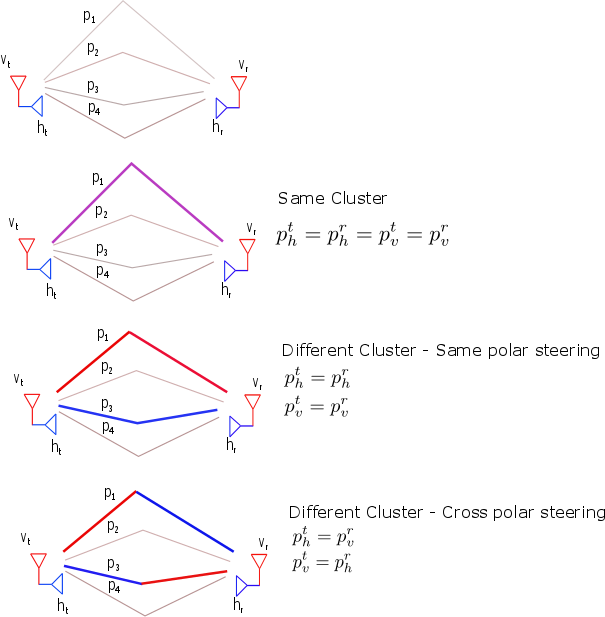

In [6]:
Image("img/cluster.png")

__path gain of each combination__

In [7]:
cluster = np.arange(Nc)
print(cluster)
c = list(itertools.combinations(cluster, 2))
num_path = (2*Nc-1)*Nc
path_combi = np.zeros((num_path,4),dtype=int)

print(path_combi.shape)
path_combi[0:Nc,:]=np.arange(Nc).reshape(Nc,1).repeat(4,axis=1)

count = 0
for i in range(int(Nc*(Nc-1)/2)):
    path_combi[Nc+4*i,:] = np.array([c[count][0],c[count][0],c[count][1],c[count][1]])
    path_combi[Nc+4*i+1,:] = np.array([c[count][1],c[count][1],c[count][0],c[count][0]])
    path_combi[Nc+4*i+2,:] = np.array([c[count][0],c[count][1],c[count][1],c[count][0]])
    path_combi[Nc+4*i+3,:] = np.array([c[count][1],c[count][0],c[count][0],c[count][1]])
    count = count+1
# print(path_combi[0:10,:])
path_gain = np.zeros((num_path,realization)) # 2 to save the position and maximum value
for reali in range(realization):
    for combi in range(num_path):
        path_gain[combi,reali] =\
        (np.abs\
         ((np.cos(ele_rot[reali])*np.cos(azi_rot[reali])*alpha_hh[path_combi[combi,0],reali]+np.sin(ele_rot[reali])*alpha_vh[path_combi[combi,0],reali])*(path_combi[combi,0]==path_combi[combi,1])+\
         (np.cos(ele_rot[reali])*np.cos(azi_rot[reali])*alpha_hv[path_combi[combi,2],reali]+np.sin(ele_rot[reali])*alpha_vv[path_combi[combi,2],reali])*(path_combi[combi,2]==path_combi[combi,1])+\
         (-np.sin(ele_rot[reali])*np.cos(azi_rot[reali])*alpha_hh[path_combi[combi,0],reali]+np.cos(ele_rot[reali])*alpha_vh[path_combi[combi,0],reali])*(path_combi[combi,0]==path_combi[combi,3])+\
         (-np.sin(ele_rot[reali])*np.cos(azi_rot[reali])*alpha_hv[path_combi[combi,2],reali]+np.cos(ele_rot[reali])*alpha_vv[path_combi[combi,2],reali])*(path_combi[combi,2]==path_combi[combi,3])
         ))**2


[0 1 2 3 4 5]
(66, 4)


In [8]:
path_gain.shape

(66, 1000)

__Check maximum gain from combination of path in each realization__

In [9]:
index = np.zeros(realization,dtype=int)
for test in range(realization):
    index[test] = np.argmax(path_gain[:,test])
    #print(path_gain[index,test])

In [10]:
print(path_combi)

[[0 0 0 0]
 [1 1 1 1]
 [2 2 2 2]
 [3 3 3 3]
 [4 4 4 4]
 [5 5 5 5]
 [0 0 1 1]
 [1 1 0 0]
 [0 1 1 0]
 [1 0 0 1]
 [0 0 2 2]
 [2 2 0 0]
 [0 2 2 0]
 [2 0 0 2]
 [0 0 3 3]
 [3 3 0 0]
 [0 3 3 0]
 [3 0 0 3]
 [0 0 4 4]
 [4 4 0 0]
 [0 4 4 0]
 [4 0 0 4]
 [0 0 5 5]
 [5 5 0 0]
 [0 5 5 0]
 [5 0 0 5]
 [1 1 2 2]
 [2 2 1 1]
 [1 2 2 1]
 [2 1 1 2]
 [1 1 3 3]
 [3 3 1 1]
 [1 3 3 1]
 [3 1 1 3]
 [1 1 4 4]
 [4 4 1 1]
 [1 4 4 1]
 [4 1 1 4]
 [1 1 5 5]
 [5 5 1 1]
 [1 5 5 1]
 [5 1 1 5]
 [2 2 3 3]
 [3 3 2 2]
 [2 3 3 2]
 [3 2 2 3]
 [2 2 4 4]
 [4 4 2 2]
 [2 4 4 2]
 [4 2 2 4]
 [2 2 5 5]
 [5 5 2 2]
 [2 5 5 2]
 [5 2 2 5]
 [3 3 4 4]
 [4 4 3 3]
 [3 4 4 3]
 [4 3 3 4]
 [3 3 5 5]
 [5 5 3 3]
 [3 5 5 3]
 [5 3 3 5]
 [4 4 5 5]
 [5 5 4 4]
 [4 5 5 4]
 [5 4 4 5]]


In [11]:
path_gain[:,1]

array([  5.47761025e-01,   2.20066008e+00,   2.21468887e-01,
         7.04946907e-03,   1.90592635e-01,   5.41000743e-01,
         1.27089032e+00,   1.34309795e-01,   2.78033499e-01,
         2.80639839e-01,   6.28738847e-02,   3.37794891e+00,
         3.70339182e-02,   1.12497016e+00,   1.22162587e-03,
         1.56710853e-01,   1.00113412e-02,   1.18830458e-01,
         1.73996941e-02,   4.62731604e-01,   1.54607772e-02,
         1.38597141e-01,   5.85963143e-01,   1.08509881e+00,
         1.69082229e-01,   2.85887801e-02,   8.85650704e-01,
         5.63637498e+00,   7.72853685e-02,   8.39488566e-01,
         6.38454620e-01,   1.07342067e+00,   8.37761434e-02,
         3.80276104e-01,   6.46368072e-01,   1.28846697e+00,
         7.91075582e-02,   3.00400061e-01,   1.88631282e+00,
         1.02128090e+00,   1.18094893e-01,   4.50815583e-01,
         1.92357866e+00,   1.33201194e-01,   1.63120561e+00,
         7.21105035e-03,   1.84548703e+00,   2.44496139e-02,
         1.67328213e+00,

In [12]:
cross_index =  []
count = Nc+1
while (count<num_path):
    cross_index.extend([count+1,count+2])
    count = count + 4
cross_index = np.array(cross_index)

In [13]:
print(cross_index)
print(cross_index.shape)
print(path_combi[index[1]])

[ 8  9 12 13 16 17 20 21 24 25 28 29 32 33 36 37 40 41 44 45 48 49 52 53 56
 57 60 61 64 65]
(30,)
[2 2 1 1]


In [14]:
cross_index_in = np.isin(index, cross_index)
# print(cross_index_in)
print('Number of Cross Index chosen in 1000 realization: ',sum(cross_index_in))

Number of Cross Index chosen in 1000 realization:  238


In [15]:
diff_clus_index = np.arange(6,66)
diff_clus_index_in = np.isin(index, diff_clus_index)
# print(diff_clus_index_in)
print('Numver of Different Cluster chosen in 1000 realization: ',sum(diff_clus_index_in))

Numver of Different Cluster chosen in 1000 realization:  444


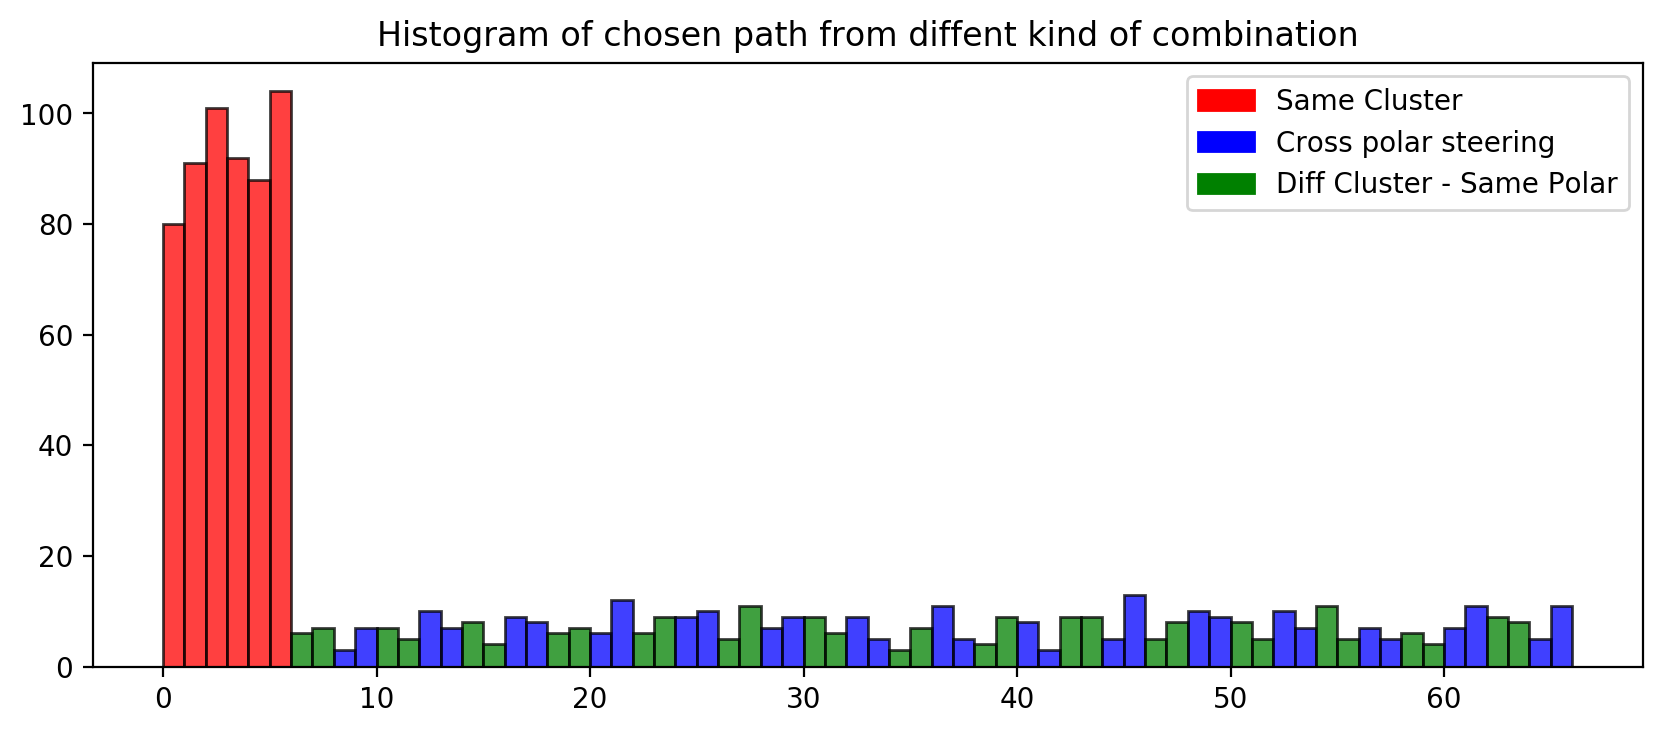

In [16]:
fig = plt.figure(figsize=(10,4), dpi=200)
n, bins, patches = plt.hist(index, bins=range(0,67),facecolor='green', alpha=0.75,edgecolor='black')
# print(n.shape)
# print(bins.shape)
# print(n)
# print(bins)
for i in range(0,6):
    patches[i].set_fc('r')
for i in cross_index:
    patches[i].set_fc('b')
    
cluster_same = mpatches.Patch(color='red', label='Same Cluster')
cross_polar = mpatches.Patch(color='blue', label='Cross polar steering')
diff_clus_same_polar = mpatches.Patch(color='green', label='Diff Cluster - Same Polar')

plt.legend(handles=[cluster_same,cross_polar,diff_clus_same_polar])
plt.title('Histogram of chosen path from diffent kind of combination')
plt.show()


In [17]:
unique, counts = np.unique(index, return_counts=True)
print(dict(zip(unique, counts)))


{0: 80, 1: 91, 2: 101, 3: 92, 4: 88, 5: 104, 6: 6, 7: 7, 8: 3, 9: 7, 10: 7, 11: 5, 12: 10, 13: 7, 14: 8, 15: 4, 16: 9, 17: 8, 18: 6, 19: 7, 20: 6, 21: 12, 22: 6, 23: 9, 24: 9, 25: 10, 26: 5, 27: 11, 28: 7, 29: 9, 30: 9, 31: 6, 32: 9, 33: 5, 34: 3, 35: 7, 36: 11, 37: 5, 38: 4, 39: 9, 40: 8, 41: 3, 42: 9, 43: 9, 44: 5, 45: 13, 46: 5, 47: 8, 48: 10, 49: 9, 50: 8, 51: 5, 52: 10, 53: 7, 54: 11, 55: 5, 56: 7, 57: 5, 58: 6, 59: 4, 60: 7, 61: 11, 62: 9, 63: 8, 64: 5, 65: 11}


### Distribution of each kind of combination by simulation

__Same Cluster__

In [18]:
index_sameclus = np.zeros(realization,dtype=int)
for reali in range(realization):
    index_sameclus[reali] = np.argmax(path_gain[0:6,reali])

In [19]:
gain_sameclus = np.zeros(realization,dtype=float)
for reali in range(realization):
    gain_sameclus[reali] = path_gain[index_sameclus[reali],reali]

__Different Cluster-Cross Polar__

In [20]:
cross_index

array([ 8,  9, 12, 13, 16, 17, 20, 21, 24, 25, 28, 29, 32, 33, 36, 37, 40,
       41, 44, 45, 48, 49, 52, 53, 56, 57, 60, 61, 64, 65])

In [21]:
index_diffclus_crosspol = np.zeros(realization,dtype=int)
for reali in range(realization):
    index_diffclus_crosspol[reali] = np.argmax(path_gain[cross_index,reali])

In [22]:
gain_diffclus_crosspol = np.zeros(realization,dtype=float)
for reali in range(realization):
    gain_diffclus_crosspol[reali] = path_gain[cross_index[np.argmax(path_gain[cross_index,reali])],reali]

__Plot the Distribution__

Average of Same Cluster Gain Distribution: 12.5666953889
Average of Different Cluster - Cross polar Gain Distribution: 7.47816685914


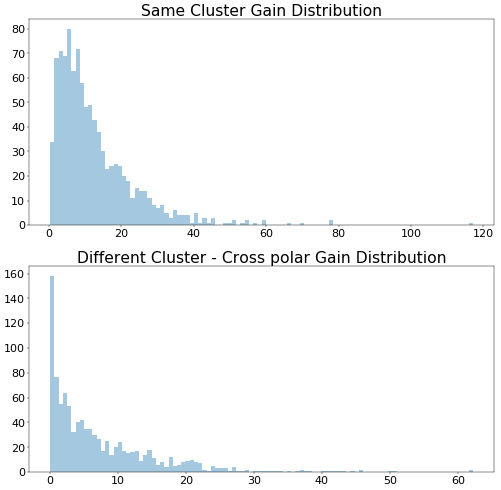

In [23]:
fig = plt.figure(figsize=(15,15), dpi=40)

plt.subplot(2, 1, 1)
plt.title('Same Cluster Gain Distribution', fontsize = 28)
sns.distplot(gain_sameclus,bins=100, kde = False)
plt.tick_params(axis='both', which='major', labelsize=20)
print('Average of Same Cluster Gain Distribution:',np.mean(gain_sameclus))

plt.subplot(2, 1, 2)
plt.title('Different Cluster - Cross polar Gain Distribution', fontsize = 28)
sns.distplot(gain_diffclus_crosspol,bins=100, kde = False)
plt.tick_params(axis='both', which='major', labelsize=20)
print('Average of Different Cluster - Cross polar Gain Distribution:',np.mean(gain_diffclus_crosspol))

### Independent Beam Steering Horizontal | Vertical 

In [24]:
steer_path = np.zeros((2,realization),dtype=int)
for reali in range(realization):
    steer_path[0,reali] = np.argmax((np.abs(alpha_hh[:,reali]))**2)
    steer_path[1,reali] = np.argmax((np.abs(alpha_vv[:,reali]))**2)
    

### Plot Spectral Efficiency

In [25]:
SNR_dB = np.arange(-35,10,5)
SNR = 10**(SNR_dB/10)
smax = SNR.shape[0]
R_cross = np.zeros([smax, realization],dtype=complex)
R_steer = np.zeros([smax, realization],dtype=complex)

for reali in range(realization):
    _chosen_combi_path = path_combi[index[reali]]
    _chosen_steer_path = steer_path[:,reali]
    
    W_cross = np.vstack((Ar[:,[_chosen_combi_path[1]],reali],Ar[:,[_chosen_combi_path[3]],reali]))
    F_cross = np.vstack((At[:,[_chosen_combi_path[0]],reali],At[:,[_chosen_combi_path[2]],reali]))
    
    W_steer = np.vstack((Ar[:,[_chosen_steer_path[0]],reali],Ar[:,[_chosen_steer_path[1]],reali]))
    F_steer = np.vstack((At[:,[_chosen_steer_path[0]],reali],At[:,[_chosen_steer_path[1]],reali]))
    
    for s in range(smax):
        R_cross[s,reali] = np.log2(np.linalg.det(np.eye(Ns)+SNR[s]/Ns*np.linalg.pinv(W_cross)@H[:,:,reali]@F_cross@F_cross.conj().T@H[:,:,reali].conj().T@W_cross))
        R_steer[s,reali] = np.log2(np.linalg.det(np.eye(Ns)+SNR[s]/Ns*np.linalg.pinv(W_steer)@H[:,:,reali]@F_steer@F_steer.conj().T@H[:,:,reali].conj().T@W_steer))

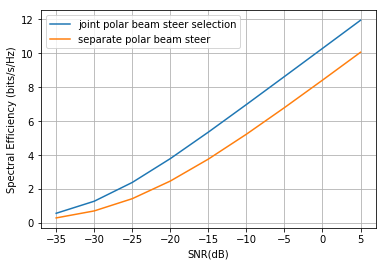

In [27]:
plt.plot(SNR_dB, (np.sum(R_cross,axis=1).real)/realization, label='joint polar beam steer selection')
plt.plot(SNR_dB, (np.sum(R_steer,axis=1).real)/realization, label='separate polar beam steer')

plt.legend(loc='upper left')
plt.xlabel('SNR(dB)')
plt.ylabel('Spectral Efficiency (bits/s/Hz)')
plt.grid()
plt.show()